In [31]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.ar_model import AutoReg
import time
import warnings
from sklearn.decomposition import PCA
import pandas as pd
from matplotlib import ticker
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RepeatedKFold, RandomizedSearchCV
from scipy.stats import uniform, loguniform, randint
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
warnings.filterwarnings("ignore") # para ignorar os warnings de funcoes
plt.rcParams['figure.figsize'] = [16, 8] # para aumentar o tamanho das figuras
plt.rcParams.update({'font.size': 16}) # para aumentar a fonte das palavras nos graficos

## Lendo os dados
Código fornecido pelo Prof Helon Ayala

In [3]:
fname = os.getcwd() + '\\..\\data\\data3SS2009.mat'

mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)

# y

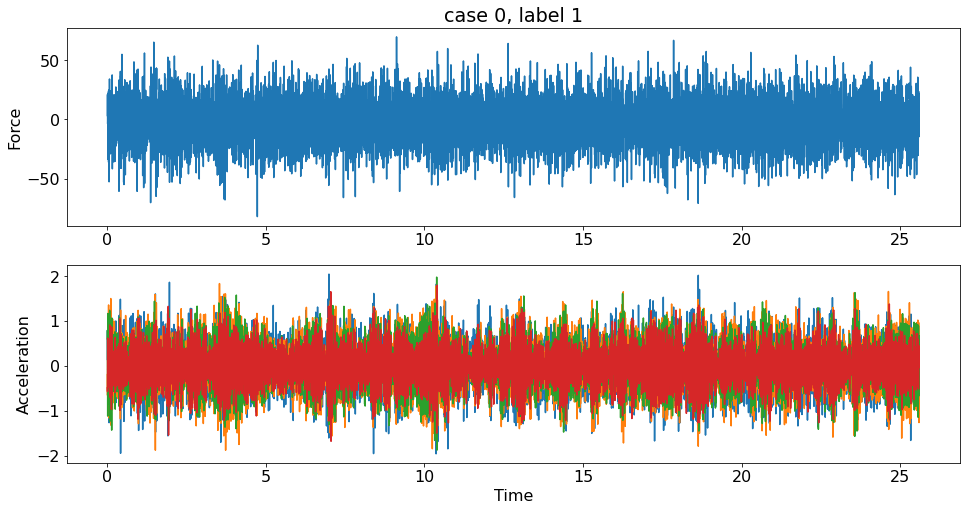

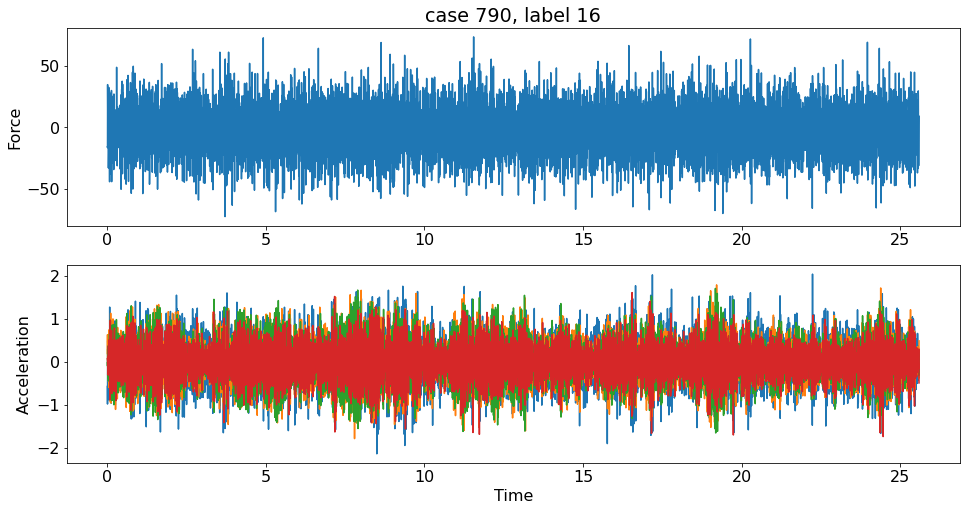

In [4]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time_vec = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time_vec,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time_vec,Ch2[:,case],time_vec,Ch3[:,case],time_vec,Ch4[:,case],time_vec,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

## Ajustando modelos AR-X

In [5]:
t_ini = time.time()

lag = 29 # escolhido o 29 para que a matriz X1 tenha o formato 850x120
canais = [Ch2, Ch3, Ch4, Ch5]

X1 = []

for amostra in range(850): # loop sobre as amostras medidas (series temporais)
    
    parametros = []
    
    for canal in canais: # loop sobre os 4 canais de interesse
        
        ajuste = AutoReg(canal[:,amostra],lags=lag).fit()
        parametros.append(ajuste.params) # montando cada uma das 850 linhas da matriz
        
    X1.append(np.hstack(parametros)) # inserindo a linha na matriz

X1 = np.array(X1)

t_final = time.time()

print('Processo de ajuste dos modelos AR demorou {:.2f} segundos.'.format((t_final - t_ini)))

print('Formato da matriz X1: {}'.format(X1.shape))

Processo de ajuste dos modelos AR demorou 38.25 segundos.
Formato da matriz X1: (850, 120)


## Aplicando o PCA

Text(0, 0.5, 'Percentual da Variância Explicada (%)')

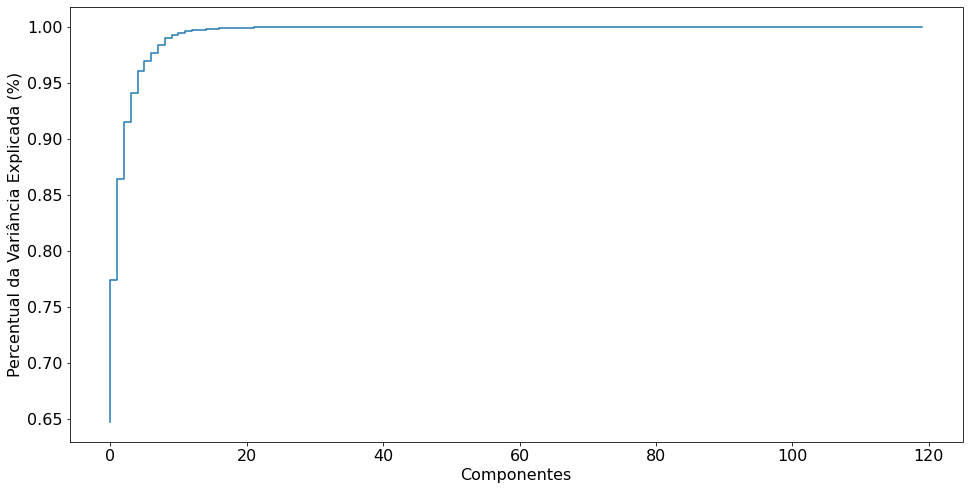

In [6]:
# Grafico que informa quanto da variancia e explicada utilizando X componentes

pca_full = PCA().fit(X1)

var_exp = pca_full.explained_variance_ratio_
var_cumu = np.cumsum(var_exp)

plt.step(range(0,len(var_cumu)),var_cumu)

plt.xlabel('Componentes')
plt.ylabel('Percentual da Variância Explicada (%)')


O gráfico acima mostra que grande parte das informações presente nos dados medidos pode ser bem representada com um número muito menor de componentes. Por exemplo, a curva se aproxima bastante de 100% a partir de 25 componentes.

Porcentagem da variancia explicada por cada componente:
Componente 1: 64.70%
Componente 2: 12.65%
Componente 3: 9.02%
Componente 4: 5.11%
Componente 5: 2.62%
Componente 6: 1.95%
Componente 7: 0.86%
Componente 8: 0.75%
Componente 9: 0.73%


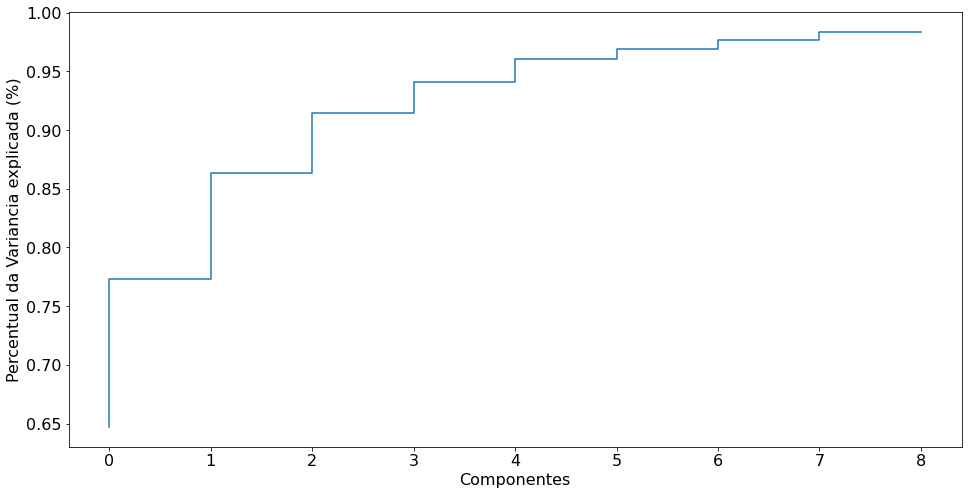

In [7]:
meta_variancia_exp = 0.98

pca = PCA(n_components = meta_variancia_exp, svd_solver = 'full').fit(X1)

var_exp = pca.explained_variance_ratio_
var_cumu = np.cumsum(var_exp)

plt.step(range(0,len(var_cumu)),var_cumu)

plt.xlabel('Componentes')
plt.ylabel('Percentual da Variancia explicada (%)')

print('Porcentagem da variancia explicada por cada componente:')
for i in range(len(var_exp)):
    print('Componente {}: {:.2f}%'.format(i+1, var_exp[i]*100))

X2 = pca.transform(X1)

Para garantir que 98% da variância consiga ser bem representada, basta utilizar 9 componentes, em que a capacidade que cada um tem para representar a variância nos dados está apresentada na célula acima.

## Normalizando as features

In [8]:
scaler = MinMaxScaler(feature_range=(-1,1))

X1_scaled = scaler.fit(X1).transform(X1)

X2_scaled = scaler.fit(X2).transform(X2)

## Visualizando e Comparando X1 e X2

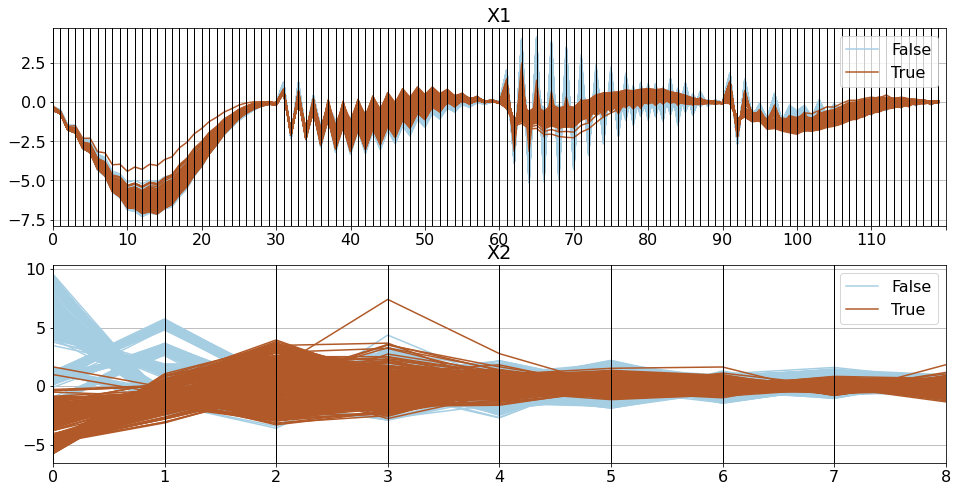

In [9]:
indDam = y > 9

dfX1 = pd.concat([pd.DataFrame(X1),pd.DataFrame({'target':indDam})],axis=1)
dfX2 = pd.concat([pd.DataFrame(X2),pd.DataFrame({'target':indDam})],axis=1)

fig = plt.figure()
ax1 = fig.add_subplot(211)
pd.plotting.parallel_coordinates(dfX1,'target',colormap=plt.get_cmap('Paired'))
ax1.title.set_text('X1')
plt.xticks(np.arange(0, 121, 10))


ax2 = fig.add_subplot(212)
pd.plotting.parallel_coordinates(dfX2,'target',colormap=plt.get_cmap('Paired'))
ax2.title.set_text('X2')

## Visualizando X1 e X2 normalizados

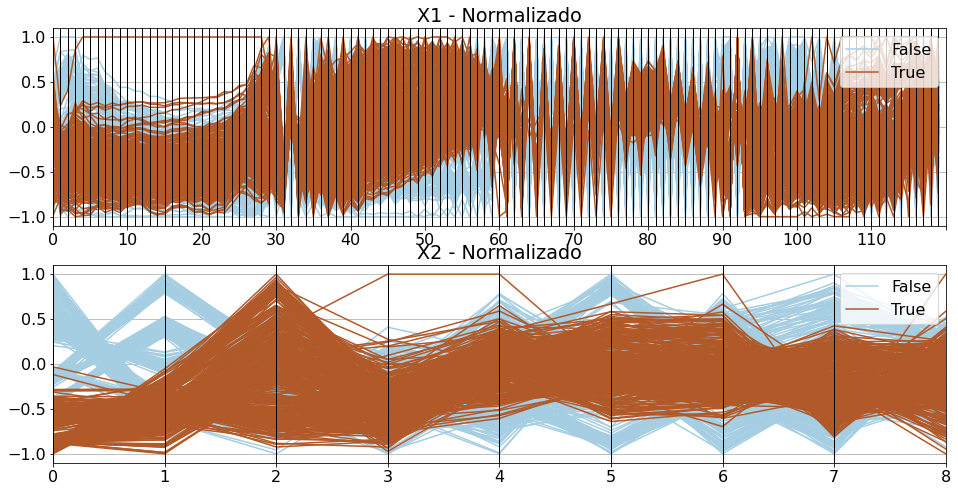

In [10]:
indDam = y > 9

dfX1_scaled = pd.concat([pd.DataFrame(X1_scaled),pd.DataFrame({'target':indDam})],axis=1)
dfX2_scaled = pd.concat([pd.DataFrame(X2_scaled),pd.DataFrame({'target':indDam})],axis=1)

fig = plt.figure()
ax1 = fig.add_subplot(211)
pd.plotting.parallel_coordinates(dfX1_scaled,'target',colormap=plt.get_cmap('Paired'))
ax1.title.set_text('X1 - Normalizado')
plt.xticks(np.arange(0, 121, 10))


ax2 = fig.add_subplot(212)
pd.plotting.parallel_coordinates(dfX2_scaled,'target',colormap=plt.get_cmap('Paired'))
ax2.title.set_text('X2 - Normalizado')

# Desempenho com hiperparâmetros default

In [11]:
class Resultados_model:
    def __init__(self, score_train, score_test, cm_test):
        self.score_train = score_train
        self.score_test = score_test
        self.cm = cm_test
        
    def save_param(self, dic):
        self.param = dic
        
    def print_param(self):
        for param in self.param.keys():
            if isinstance(self.param[param], np.floating):
                print('  {} = {:.2f}'.format(param, self.param[param]))
            else:            
                print('  {} = {}'.format(param, self.param[param]))
                
        print('')
                
    def print_resultados(self):
        print('# Resultados:')
        print('  Train score = {:.4f}'.format(self.score_train))
        print('  Test score = {:.4f}'.format(self.score_test))
        print('')
        

In [12]:
# criando as variáveis que serão usadas em todo o processo
rand_seed = 314

X2_tr, X2_te, y_tr, y_te = train_test_split(X2, y, random_state = rand_seed, test_size = 0.3)

rkf = RepeatedKFold(n_splits = 5, n_repeats = 50, random_state = rand_seed)

## Modelo Softmax

Score train: 0.9664;
Score test: 0.9569;


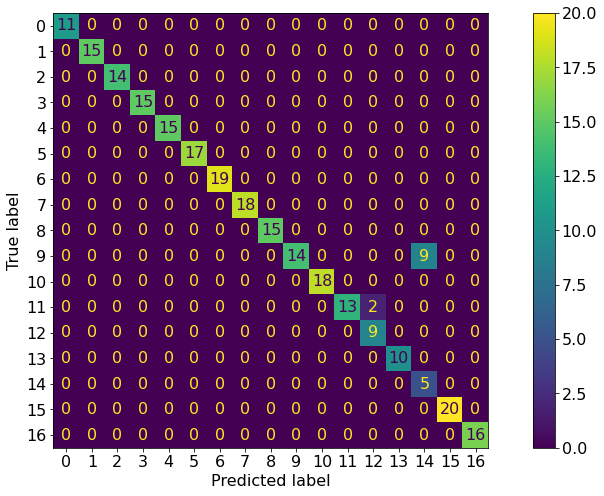

In [13]:
resultados_default = {}

logreg_X2 = LogisticRegression().fit(X2_tr, y_tr)

score_train = logreg_X2.score(X2_tr, y_tr)
score_test = logreg_X2.score(X2_te, y_te)

print('Score train: {:.4f};'.format(score_train))
print('Score test: {:.4f};'.format(score_test))

# plotando a matriz de confusao para os dados de teste
cm_test = confusion_matrix(y_te, logreg_X2.predict(X2_te))
ConfusionMatrixDisplay(cm_test).plot()

resultados_default['softmax'] = Resultados_model(score_train, score_test, cm_test)
resultados_default['softmax'].save_param(logreg_X2.get_params())

## Model SVM

Score train: 0.9042;
Score test: 0.8353;


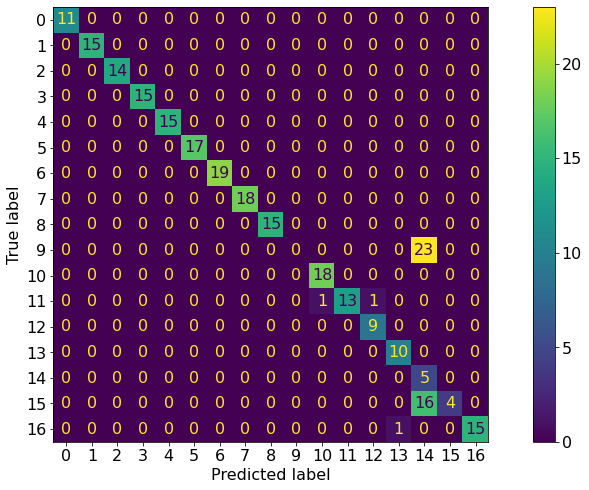

In [14]:
SVM_X2 = SVC().fit(X2_tr, y_tr)

score_train = SVM_X2.score(X2_tr, y_tr)
score_test = SVM_X2.score(X2_te, y_te)

print('Score train: {:.4f};'.format(score_train))
print('Score test: {:.4f};'.format(score_test))

# plotando a matriz de confusao para os dados de teste
cm_test = confusion_matrix(y_te, SVM_X2.predict(X2_te))
ConfusionMatrixDisplay(cm_test).plot()

resultados_default['SVM'] = Resultados_model(score_train, score_test, cm_test)
resultados_default['SVM'].save_param(SVM_X2.get_params())

## Modelo kNN

Score train: 0.9529;
Score test: 0.9137;


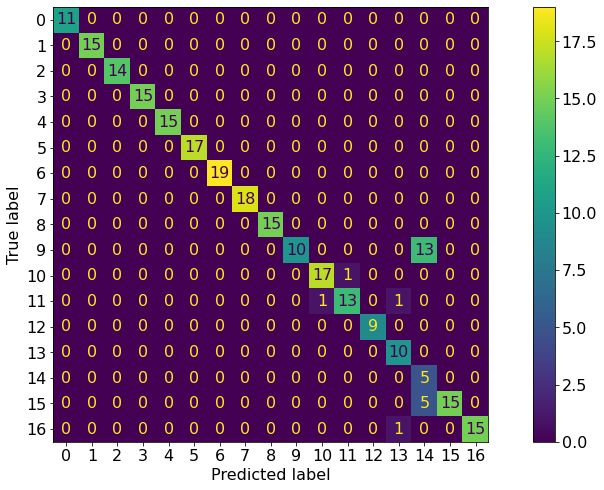

In [15]:
kNN_X2 = KNeighborsClassifier().fit(X2_tr, y_tr)

score_train = kNN_X2.score(X2_tr, y_tr)
score_test = kNN_X2.score(X2_te, y_te)

print('Score train: {:.4f};'.format(score_train))
print('Score test: {:.4f};'.format(score_test))

# plotando a matriz de confusao para os dados de teste
cm_test = confusion_matrix(y_te, kNN_X2.predict(X2_te))
ConfusionMatrixDisplay(cm_test).plot()

resultados_default['kNN'] = Resultados_model(score_train, score_test, cm_test)
resultados_default['kNN'].save_param(kNN_X2.get_params())

## Modelo Decision Tree Classifier

Score train: 1.0000;
Score test: 0.9059;


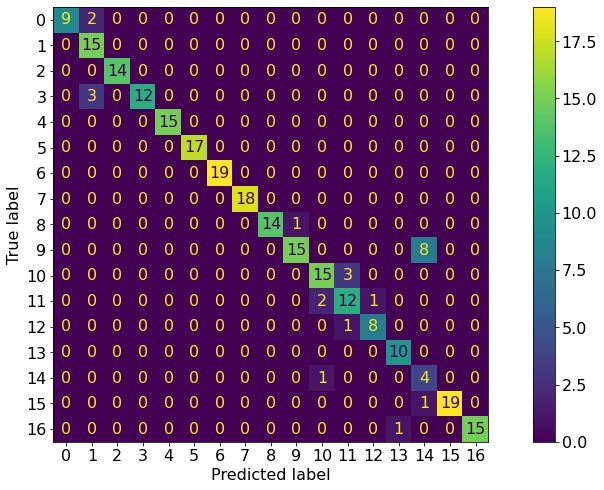

In [24]:
DTC_X2 = DecisionTreeClassifier().fit(X2_tr, y_tr)

score_train = DTC_X2.score(X2_tr, y_tr)
score_test = DTC_X2.score(X2_te, y_te)

print('Score train: {:.4f};'.format(score_train))
print('Score test: {:.4f};'.format(score_test))

# plotando a matriz de confusao para os dados de teste
cm_test = confusion_matrix(y_te, DTC_X2.predict(X2_te))
ConfusionMatrixDisplay(cm_test).plot()

resultados_default['DTC'] = Resultados_model(score_train, score_test, cm_test)
resultados_default['DTC'].save_param(DTC_X2.get_params())

## Modelo Random Forest Classifier

Score train: 1.0000;
Score test: 0.9647;


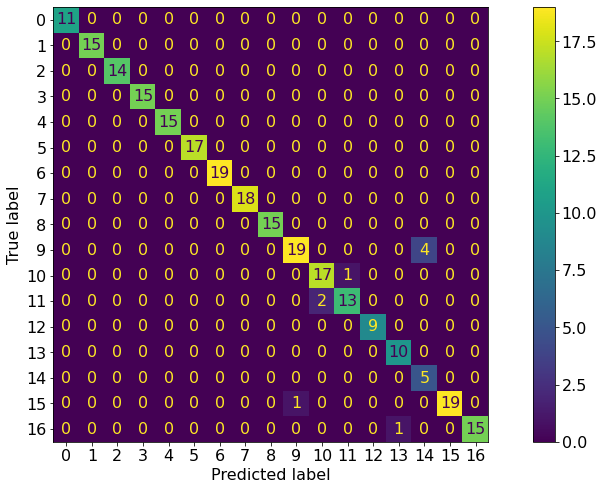

In [32]:
RFC_X2 = RandomForestClassifier().fit(X2_tr, y_tr)

score_train = RFC_X2.score(X2_tr, y_tr)
score_test = RFC_X2.score(X2_te, y_te)

print('Score train: {:.4f};'.format(score_train))
print('Score test: {:.4f};'.format(score_test))

# plotando a matriz de confusao para os dados de teste
cm_test = confusion_matrix(y_te, RFC_X2.predict(X2_te))
ConfusionMatrixDisplay(cm_test).plot()

resultados_default['RFC'] = Resultados_model(score_train, score_test, cm_test)
resultados_default['RFC'].save_param(RFC_X2.get_params())

# Hyperparameter Tuning

## Modelo Softmax

Para o modelo Softmax, os parâmetros que serão pesquisados são:
  - a norma da penalização (none, l2);
  - C (0.01 a 100).

# Hiperparâmetros ótimos encontrados:
  softmax__C = 49.03
  softmax__penalty = l2

# Resultados:
  Train score = 0.9832
  Test score = 0.9804

O processo demorou 327.8 segundos.


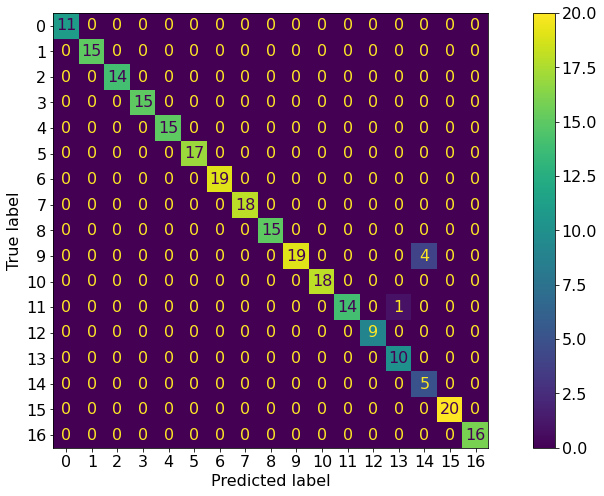

In [16]:
resultados_otim = {}

t_ini = time.time()

param_grid = {
    'softmax__penalty': ['None', 'l2'], # valores aceitos para o solver = lbfgs
    'softmax__C': loguniform(0.01, 100)
}

model = ([('softmax', LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', max_iter=1000))])
# model = ([('softmax', LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs'))])

clf = Pipeline(model)

random_search = RandomizedSearchCV(clf, verbose = 0, scoring = 'accuracy', n_iter = 100, n_jobs = -1, 
                                   cv = rkf, param_distributions = param_grid)

random_search.fit(X2_tr, y_tr)

score_train = random_search.score(X2_tr, y_tr)
score_test = random_search.score(X2_te, y_te)

cm_test = confusion_matrix(y_te, random_search.predict(X2_te))
ConfusionMatrixDisplay(cm_test).plot()

resultados_otim['softmax'] = Resultados_model(score_train, score_test, cm_test)
resultados_otim['softmax'].save_param(random_search.best_params_)

print('# Hiperparâmetros ótimos encontrados:')
resultados_otim['softmax'].print_param()
resultados_otim['softmax'].print_resultados()

t_final = time.time()

print('O processo demorou {:.1f} segundos.'.format(t_final-t_ini))

## Modelo SVM

Para o modelo SVM, os parâmetros que serão pesquisados são os mesmos testados no exercício da semana 3:
  - C (0.1 a 100);
  - Kernel (linear, fbr e poly);
  - Para kernel polinomial, degree (1 a 6).

# Hiperparâmetros ótimos encontrados:
  SVM__C = 10.02
  SVM__degree = 2
  SVM__kernel = linear

# Resultados:
  Train score = 0.9832
  Test score = 0.9882

O processo demorou 19.9 segundos.


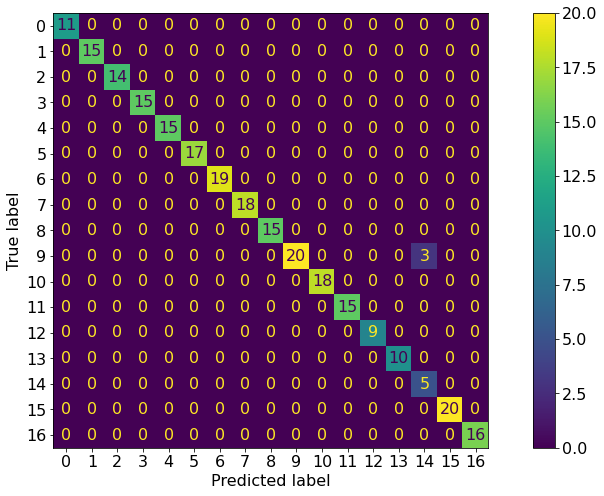

In [17]:
t_ini = time.time()

param_grid = {
    'SVM__C': loguniform(0.1, 1000),
    'SVM__kernel': ['linear', 'fbr', 'poly'],
    'SVM__degree': randint(2, 6)
}

model = ([('SVM', SVC())])

clf = Pipeline(model)

random_search = RandomizedSearchCV(clf, verbose = 0, scoring = 'accuracy', n_iter = 100, n_jobs = -1, 
                                   cv = rkf, param_distributions = param_grid)

random_search.fit(X2_tr, y_tr)

score_train = random_search.score(X2_tr, y_tr)
score_test = random_search.score(X2_te, y_te)

cm_test = confusion_matrix(y_te, random_search.predict(X2_te))
ConfusionMatrixDisplay(cm_test).plot()

resultados_otim['SVM'] = Resultados_model(score_train, score_test, cm_test)
resultados_otim['SVM'].save_param(random_search.best_params_)

print('# Hiperparâmetros ótimos encontrados:')
resultados_otim['SVM'].print_param()
resultados_otim['SVM'].print_resultados()

t_final = time.time()

print('O processo demorou {:.1f} segundos.'.format(t_final-t_ini))

## Modelo kNN

Para o modelo kNN, os parâmetros que serão pesquisados são os mesmos testados no exercício da semana 3:
  - métrica (euclideana (minkowski + p=2), manhattan (minkowski + p=1) e minkowski + p = 3));
  - número de vizinhos (2 a 100).

# Hiperparâmetros ótimos encontrados:
  kNN__n_neighbors = 5
  kNN__p = 1

# Resultados:
  Train score = 0.9513
  Test score = 0.9294

O processo demorou 22.3 segundos.


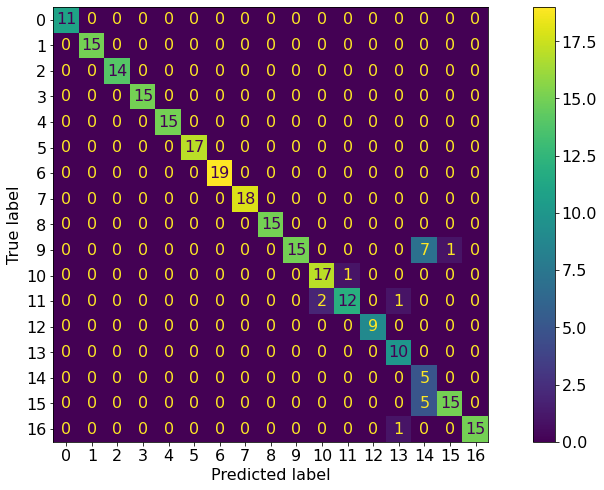

In [18]:
t_ini = time.time()

param_grid = {
    'kNN__p': randint(1,3),
    'kNN__n_neighbors': randint(2,100)
}

model = ([('kNN', KNeighborsClassifier())])

clf = Pipeline(model)

random_search = RandomizedSearchCV(clf, verbose = 0, scoring = 'accuracy', n_iter = 100, n_jobs = -1, 
                                   cv = rkf, param_distributions = param_grid)

random_search.fit(X2_tr, y_tr)

score_train = random_search.score(X2_tr, y_tr)
score_test = random_search.score(X2_te, y_te)

cm_test = confusion_matrix(y_te, random_search.predict(X2_te))
ConfusionMatrixDisplay(cm_test).plot()

resultados_otim['kNN'] = Resultados_model(score_train, score_test, cm_test)
resultados_otim['kNN'].save_param(random_search.best_params_)

print('# Hiperparâmetros ótimos encontrados:')
resultados_otim['kNN'].print_param()
resultados_otim['kNN'].print_resultados()

t_final = time.time()

print('O processo demorou {:.1f} segundos.'.format(t_final-t_ini))

## Modelo Decision Tree Classifier

Para o modelo DTC, os parâmetros que serão pesquisados são:
  - critério sobre a qualidade da divisão ('gini', 'entropy', 'log_loss');
  - estratégia utilizada para divisão em cada nó ('best', 'random');
  - profundidade máxima da árvore (2 a 20)
  - número máximo de features utilizadas durante o processo de divisão.

# Hiperparâmetros ótimos encontrados:
  DTC__criterion = gini
  DTC__max_depth = 18
  DTC__max_features = 0.82
  DTC__splitter = best

# Resultados:
  Train score = 1.0000
  Test score = 0.9137

O processo demorou 11.2 segundos.


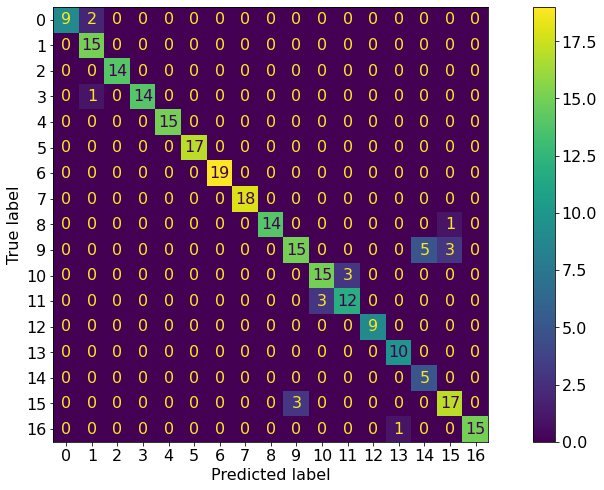

In [27]:
t_ini = time.time()

param_grid = {
    'DTC__criterion': ['gini', 'entropy', 'log_loss'],
    'DTC__splitter': ['best', 'random'],
    'DTC__max_depth': randint(2, 20),
    'DTC__max_features': uniform(),
}

model = ([('DTC', DecisionTreeClassifier())])

clf = Pipeline(model)

random_search = RandomizedSearchCV(clf, verbose = 0, scoring = 'accuracy', n_iter = 100, n_jobs = -1, 
                                   cv = rkf, param_distributions = param_grid)

random_search.fit(X2_tr, y_tr)

score_train = random_search.score(X2_tr, y_tr)
score_test = random_search.score(X2_te, y_te)

cm_test = confusion_matrix(y_te, random_search.predict(X2_te))
ConfusionMatrixDisplay(cm_test).plot()

resultados_otim['DTC'] = Resultados_model(score_train, score_test, cm_test)
resultados_otim['DTC'].save_param(random_search.best_params_)

print('# Hiperparâmetros ótimos encontrados:')
resultados_otim['DTC'].print_param()
resultados_otim['DTC'].print_resultados()

t_final = time.time()

print('O processo demorou {:.1f} segundos.'.format(t_final-t_ini))

## Modelo Random Forest Classifier

Para o modelo RFC, os parâmetros que serão pesquisados são:
  - número de árvores na floresta (2 a 20);
  - critério sobre a qualidade da divisão ('gini', 'entropy', 'log_loss');
  - profundidade máxima da árvore (2 a 20)
  - número máximo de features utilizadas durante o processo de divisão.

# Hiperparâmetros ótimos encontrados:
  RFC__criterion = gini
  RFC__max_depth = 18
  RFC__max_features = 0.39
  RFC__n_estimators = 16

# Resultados:
  Train score = 0.9933
  Test score = 0.9451

O processo demorou 59.8 segundos.


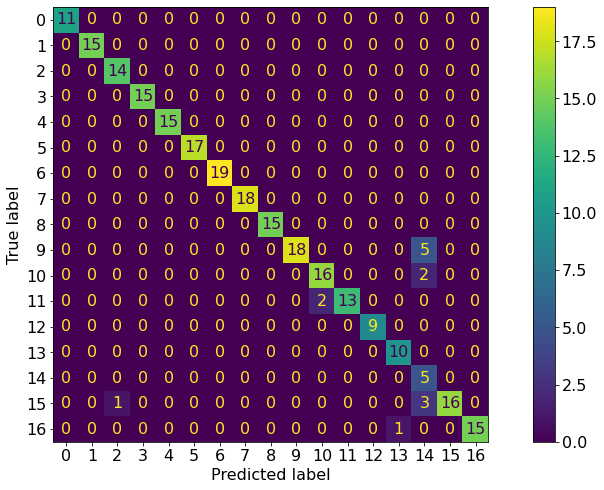

In [34]:
t_ini = time.time()

param_grid = {
    'RFC__n_estimators': randint(2, 20),
    'RFC__criterion': ['gini', 'entropy', 'log_loss'],
    'RFC__max_depth': randint(2, 20),
    'RFC__max_features': uniform(),
}

model = ([('RFC', RandomForestClassifier())])

clf = Pipeline(model)

random_search = RandomizedSearchCV(clf, verbose = 0, scoring = 'accuracy', n_iter = 100, n_jobs = -1, 
                                   cv = rkf, param_distributions = param_grid)

random_search.fit(X2_tr, y_tr)

score_train = random_search.score(X2_tr, y_tr)
score_test = random_search.score(X2_te, y_te)

cm_test = confusion_matrix(y_te, random_search.predict(X2_te))
ConfusionMatrixDisplay(cm_test).plot()

resultados_otim['RFC'] = Resultados_model(score_train, score_test, cm_test)
resultados_otim['RFC'].save_param(random_search.best_params_)

print('# Hiperparâmetros ótimos encontrados:')
resultados_otim['RFC'].print_param()
resultados_otim['RFC'].print_resultados()

t_final = time.time()

print('O processo demorou {:.1f} segundos.'.format(t_final-t_ini))

# Comparando resultados: Default x Tuned

# Modelo Softmax

# Resultados - Default:
# Resultados:
  Train score = 0.9664
  Test score = 0.9569

# Resultados - Tuned:
  softmax__C = 49.03
  softmax__penalty = l2

# Resultados:
  Train score = 0.9832
  Test score = 0.9804



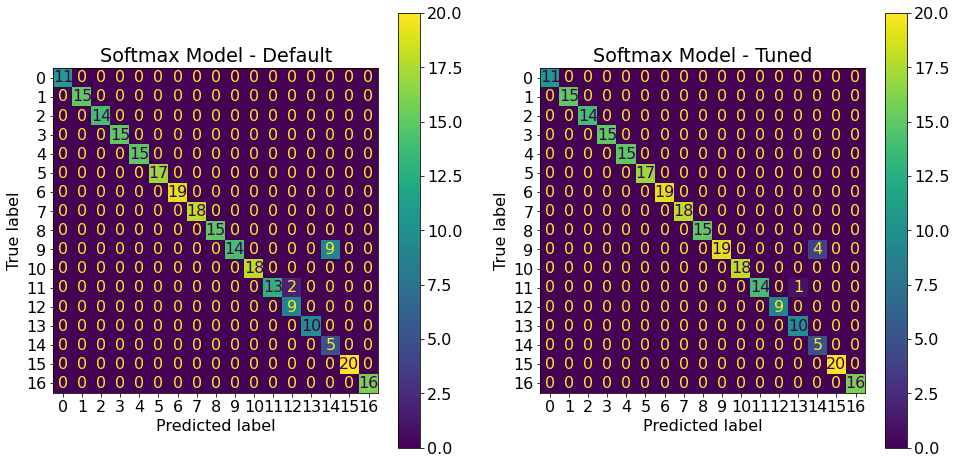

In [19]:
model = 'softmax'
fig, axs = plt.subplots(1,2)

for i in range(2):
    
    if i == 1:
        resultados = resultados_otim
        title = 'Softmax Model - Tuned'
        
    else:
        resultados = resultados_default
        title = 'Softmax Model - Default'
        
            
    cmgraph = ConfusionMatrixDisplay(resultados[model].cm)
    
    ax = axs[i]
    ax.set_title(title)
    cmgraph.plot(ax = ax)
        
print('# Resultados - Default:')
resultados_default[model].print_resultados()
print('# Resultados - Tuned:')
resultados_otim[model].print_param()
resultados_otim[model].print_resultados()


## Modelo SVM

# Resultados - Default:
# Resultados:
  Train score = 0.9042
  Test score = 0.8353

# Resultados - Tuned:
  SVM__C = 10.02
  SVM__degree = 2
  SVM__kernel = linear

# Resultados:
  Train score = 0.9832
  Test score = 0.9882



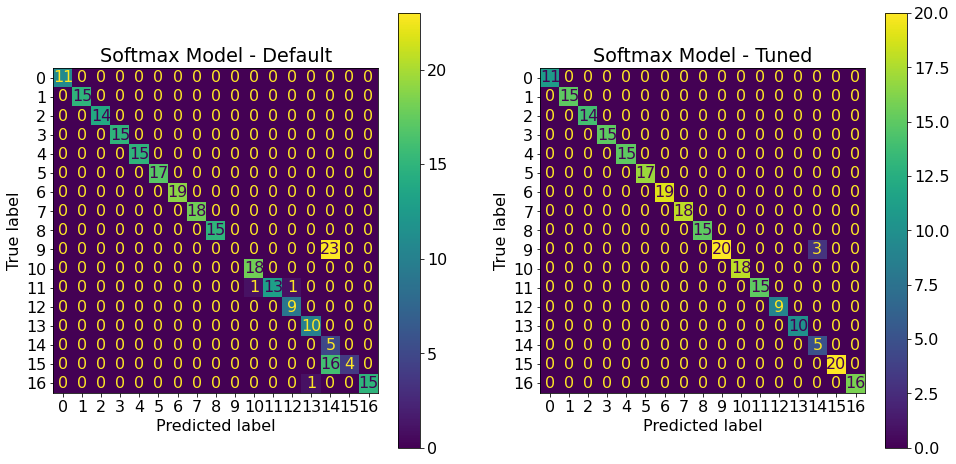

In [20]:
model = 'SVM'
fig, axs = plt.subplots(1,2)

for i in range(2):
    
    if i == 1:
        resultados = resultados_otim
        title = 'Softmax Model - Tuned'
        
    else:
        resultados = resultados_default
        title = 'Softmax Model - Default'
            
    cmgraph = ConfusionMatrixDisplay(resultados[model].cm)
    
    ax = axs[i]
    ax.set_title(title)
    cmgraph.plot(ax = ax)
        
print('# Resultados - Default:')
resultados_default[model].print_resultados()
print('# Resultados - Tuned:')
resultados_otim[model].print_param()
resultados_otim[model].print_resultados()


## Modelo kNN

# Resultados - Default:
# Resultados:
  Train score = 0.9529
  Test score = 0.9137

# Resultados - Tuned:
  kNN__n_neighbors = 5
  kNN__p = 1

# Resultados:
  Train score = 0.9513
  Test score = 0.9294



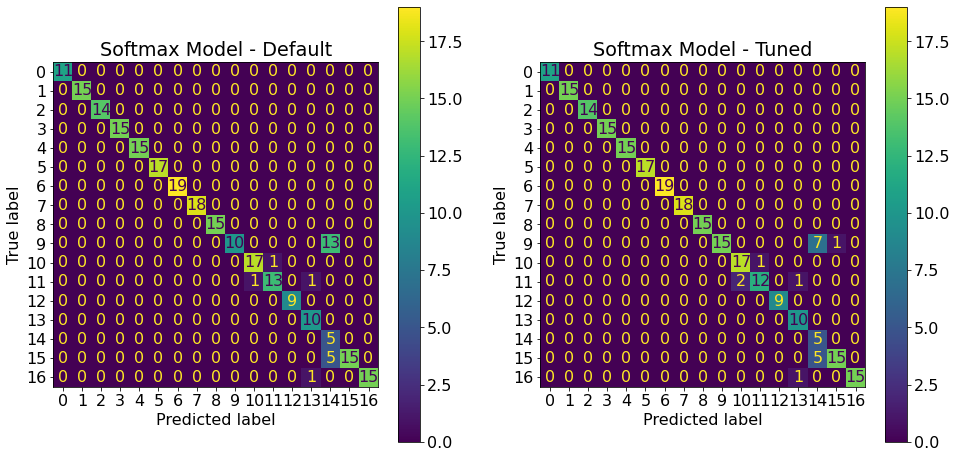

In [21]:
model = 'kNN'
fig, axs = plt.subplots(1,2)

for i in range(2):
    
    if i == 1:
        resultados = resultados_otim
        title = 'Softmax Model - Tuned'
        
    else:
        resultados = resultados_default
        title = 'Softmax Model - Default'
            
    cmgraph = ConfusionMatrixDisplay(resultados[model].cm)
    
    ax = axs[i]
    ax.set_title(title)
    cmgraph.plot(ax = ax)
        
print('# Resultados - Default:')
resultados_default[model].print_resultados()
print('# Resultados - Tuned:')
resultados_otim[model].print_param()
resultados_otim[model].print_resultados()


## Modelo Decision Tree Classifier

# Resultados - Default:
# Resultados:
  Train score = 1.0000
  Test score = 0.9059

# Resultados - Tuned:
  DTC__criterion = gini
  DTC__max_depth = 18
  DTC__max_features = 0.82
  DTC__splitter = best

# Resultados:
  Train score = 1.0000
  Test score = 0.9137



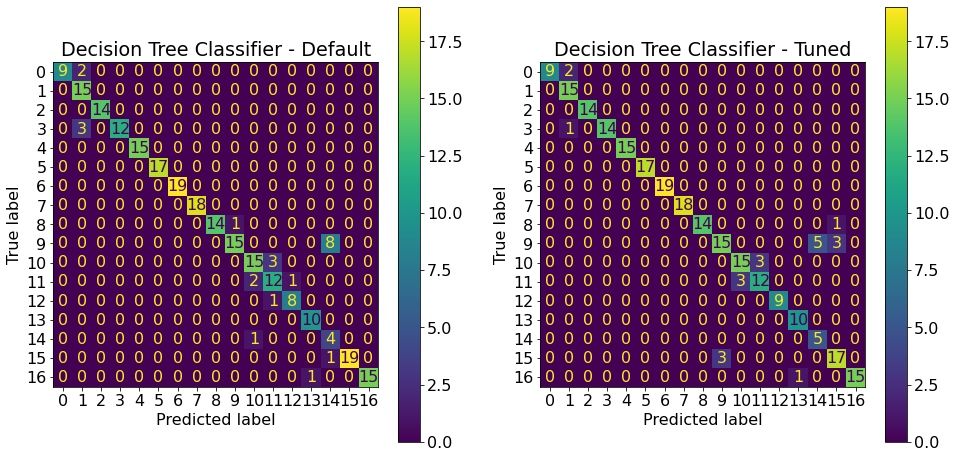

In [35]:
model = 'DTC'
fig, axs = plt.subplots(1,2)

for i in range(2):
    
    if i == 1:
        resultados = resultados_otim
        title = 'Decision Tree Classifier - Tuned'
        
    else:
        resultados = resultados_default
        title = 'Decision Tree Classifier - Default'
            
    cmgraph = ConfusionMatrixDisplay(resultados[model].cm)
    
    ax = axs[i]
    ax.set_title(title)
    cmgraph.plot(ax = ax)
        
print('# Resultados - Default:')
resultados_default[model].print_resultados()
print('# Resultados - Tuned:')
resultados_otim[model].print_param()
resultados_otim[model].print_resultados()

## Modelo Random Forest Classifier

# Resultados - Default:
# Resultados:
  Train score = 1.0000
  Test score = 0.9647

# Resultados - Tuned:
  RFC__criterion = gini
  RFC__max_depth = 18
  RFC__max_features = 0.39
  RFC__n_estimators = 16

# Resultados:
  Train score = 0.9933
  Test score = 0.9451



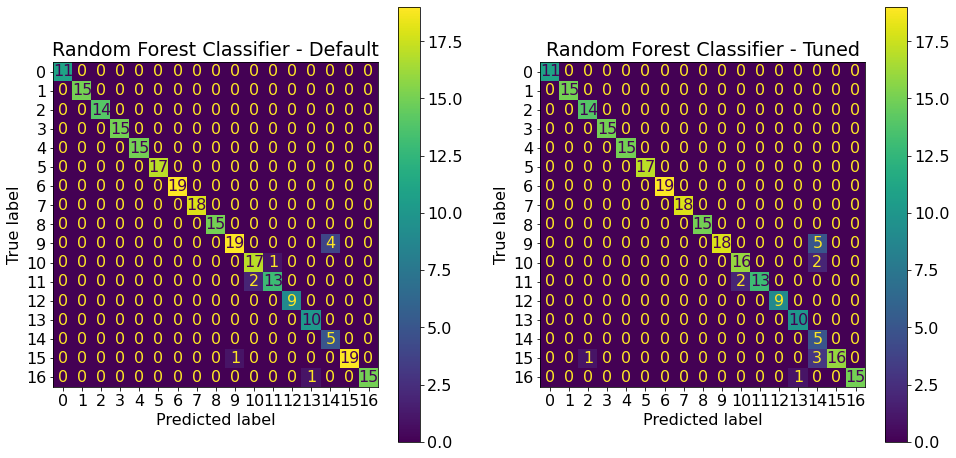

In [36]:
model = 'RFC'
fig, axs = plt.subplots(1,2)

for i in range(2):
    
    if i == 1:
        resultados = resultados_otim
        title = 'Random Forest Classifier - Tuned'
        
    else:
        resultados = resultados_default
        title = 'Random Forest Classifier - Default'
            
    cmgraph = ConfusionMatrixDisplay(resultados[model].cm)
    
    ax = axs[i]
    ax.set_title(title)
    cmgraph.plot(ax = ax)
        
print('# Resultados - Default:')
resultados_default[model].print_resultados()
print('# Resultados - Tuned:')
resultados_otim[model].print_param()
resultados_otim[model].print_resultados()

# Conclusões

O modelo de árvore de decisão não apresentou bom desempenho, mesmo após o processo de ajuste dos hiperprâmetros. Vale ressaltar, que ao contrário dos outros modelos testados, ele foi o único modelo que não conseguiu realizar predições acuradas para os estados sem dano (de 0 a 8). Apesar disso, ele errou predizendo um estado equivocado, porém sem dano também. Dessa forma, ele ainda seria útil para analisar se a estrutura está com dano ou não, apesar de não ter uma predição boa para a extensão do dano.

Já o modelo random forest apresentou um bom desempenho, mas nota-se que o processo de ajuste dos hiperparâmetros não foi capaz de melhorar a qualidade do modelo. Provavelmente foram estressadas variáveis ou ranges de variáveis insensíveis ao problema. Isso demonstra a importência de conhecer a teoria por trás do aprendizado de máquinas para poder dimensionar bem o processo de ajuste dos hiperpâmetros a dim de otimizar o desempenho do modelo.